## Introduction

In this kernel I try to elaborate about all the things which lead me to achieving this score. I try to cover every step to make sure that no one leaves this kernel without understanding my reasoning. At the end, I am going to summarize the whole thing by explaining what could have been done better as well as suggest some additional ideas which could be implemented to successfully improve current score.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression
import sys
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
filterwarnings('ignore')

train_set=pd.read_csv(r'../input/train.csv')
test_set=pd.read_csv(r'../input/test.csv')

train_test = pd.concat([train_set,test_set],axis=0).reset_index(drop=True)
train_test = train_test.drop('Id',axis=1)

## Dealing with missing values / variables scale correction 

Before doing any shenanigans we need to deal with issues which already exist on provided dataset. Some of the values in the dataset are missing because of nature of variable, but some of them may also be missing for other reasons - there things are getting a bit trickier and our role is to determine which value will fit the best. Another problem with the current state of the dataset is form of ordinal and nominal variables - some ordinal variables are encoded like nominal, but also some of the nominal variables are presented as ordinal. At this stage of data preparation, we are going to deal with all of those issues.

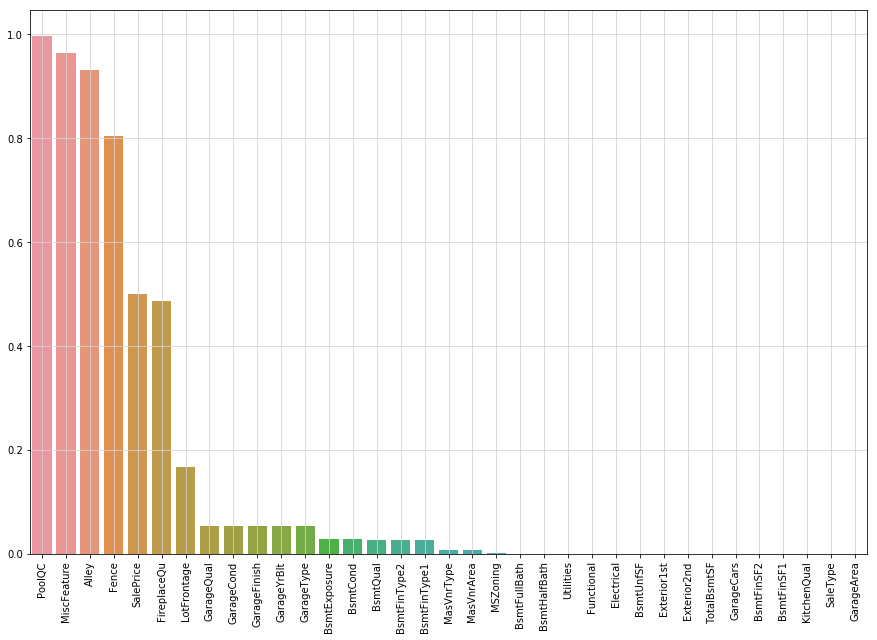

In [2]:
missing = (train_test.isnull().sum()[train_test.isnull().sum()>0] / len(train_test)).sort_values(ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=missing[missing>0].index, y=missing[missing>0].values)
plt.xticks(rotation=90)
plt.grid(b=True, color='lightgrey')

As you may see on the chart above, we have 4 variables in which missing values ratio is higher than 80%. Fortunately, we do not have to throw them out, because it is connected with the nature of this dataset. According to the instructions provided in competition files, some variables receive Null value when specific feature does not occur. So let's first take care of those variables.

In [3]:
EasyVariables = ['MiscFeature', 'MasVnrType', 'GarageType']

for var in EasyVariables:
    train_test[var] = train_test[var].fillna('DNE')

In this section we want to represent all ordinal variables in proper format. After this operation, we're also going to imput 0 in all places, where specific amenity does not appear.

In [4]:
train_test = train_test.replace({'GarageQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.NaN:0},
                                 'GarageCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.NaN:0},
                                 'GarageFinish':{'Fin':3,'RFn':2,'Unf':1,np.NaN:0},
                                 'BsmtQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                                 'BsmtCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                                 'BsmtExposure':{'Gd':4,'Av':3, 'Mn':2,'No':1,},
                                 'BsmtFinType1':{'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1},
                                 'BsmtFinType2':{'GLQ':6,'ALQ':5,'BLQ':4, 'Rec':3,'LwQ':2, 'Unf':1},
                                 'KitchenQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                                 'PoolQC':{'Ex':4,'Gd':3,'TA':2,'Fa':1,np.NaN:0},
                                 'Street':{'Pave':1,'Grvl':0},
                                 'Alley':{np.NaN:0,'Grvl':1,'Pave':2},
                                 'Fence':{'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,np.NaN:0},
                                 'Utilities':{'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1},
                                 'ExterQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                                 'ExterCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                                 'HeatingQC':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                                 'CentralAir':{'Y':1,'N':0},
                                 'PavedDrive':{'Y':3,'N':2,'P':1},
                                 'FireplaceQu':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}})






In [5]:
FillWith0 = ['BsmtFinType2', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF',
             'BsmtUnfSF','BsmtHalfBath','BsmtFullBath', 'FireplaceQu','GarageYrBlt','MasVnrArea']

for var in FillWith0:
    train_test[var] = train_test[var].fillna(0)


Some houses are missing information about their specification. Here, we are going to replace *Null* values with the most common values in each variable.

In [6]:
train_test.Utilities = train_test.Utilities.fillna(4)
train_test.Functional = train_test.Functional.fillna('Typ')
train_test.SaleType = train_test.SaleType.fillna('WD')
train_test.KitchenQual = train_test.KitchenQual.fillna(3)
train_test.Electrical = train_test.Electrical.fillna('SBrkr')
train_test.MSZoning = train_test.MSZoning.fillna('RL')

train_test[['Exterior1st','Exterior2nd']] = train_test[['Exterior1st','Exterior2nd']].fillna('VinylSd')


As I mentioned earlier, we have the variable which is represented in format known from ordinal variables, but it appears to be nominal, so in this place we are going to replace all number values with nominal values accordingly.

In [7]:
train_test = train_test.replace({'MSSubClass':{
        20:'1-STORY 1946 & NEWER ALL STYLES',
        30:'1-STORY 1945 & OLDER',
        40:'1-STORY W/FINISHED ATTIC ALL AGES',
        45:'1-1/2 STORY - UNFINISHED ALL AGES',
        50:'1-1/2 STORY FINISHED ALL AGES',
        60:'2-STORY 1946 & NEWER',
        70:'2-STORY 1945 & OLDER',
        75:'2-1/2 STORY ALL AGES',
        80:'SPLIT OR MULTI-LEVEL',
        85:'SPLIT FOYER',
        90:'DUPLEX - ALL STYLES AND AGES',
       120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
       150:'1-1/2 STORY PUD - ALL AGES',
       160:'2-STORY PUD - 1946 & NEWER',
       180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
       190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}})


Last variable which has missing values is LotFrontage, but we will deal with it after deleting with outliers.

## Outlier detection

In this section we will try to eliminate every house which may affect negatively results of modeling. Also, we will try to detect some contradictions between variables (eg. GarageArea equal to zero when every other variable shows that house has a garage). While dealing with outliers we will focus on bivariate visual detection and we focus only on couple of the most important of them. 

When preparing this kernel, I tried to create linear models in order to detect outliers both visually and by deleting them via Z-Score on residuals, but both methods failed for me.

Firstly, we will try to detect contradictions in the dataset. Unfortunately, almost all of them appears in test data, so instead of deleting an observation, we need to guess whether specific thing is in a house or not.

In [8]:
# POOL AREA > 0 
train_test.loc[[2420,2503,2599],'PoolQC'] = 3

# GARAGE AREA > 0
train_test.loc[2576,'GarageYrBlt'] = 1923
train_test.loc[2126,'GarageYrBlt'] = 1910
train_test.loc[[2576,2126],'GarageFinish'] = 1
train_test.loc[[2576,2126],'GarageQual'] = 3
train_test.loc[[2576,2126],'GarageCond'] = 3
train_test.loc[2576, 'GarageCars'] = 1
train_test.loc[2576, 'GarageArea'] = 288


# Whole garage data > 0
train_test.loc[2592,'GarageYrBlt'] = 2007

# Basement data > 0
train_test.loc[[2040, 2524, 2185, 2040],'BsmtCond'] = 3
train_test.loc[[2348,1487,948],'BsmtExposure'] = 3
train_test.loc[[2217, 2218],'BsmtQual'] = 3
train_test.loc[2284,'BsmtFinSF1'] = 638
train_test.loc[2284,'BsmtFinSF2'] = 0

# Training set so we're dropping (BasementFinType2=0)
train_test = train_test.drop(332, axis=0)
# train_test['BsmtFinType2'].loc[332] = 1

# Also training set (MiscValue=0, but it does have MistFeature)
train_test = train_test.drop([1200, 873],axis=0)

When detecting outliers I did not delete those observations which fall far away from the rest of the observations, but follows the trend. 

At this stage we are deleting only 8 outliers. I also tried to experiment with deleting other observations, but from those which I checked, deleting those eight observations worked best for me.

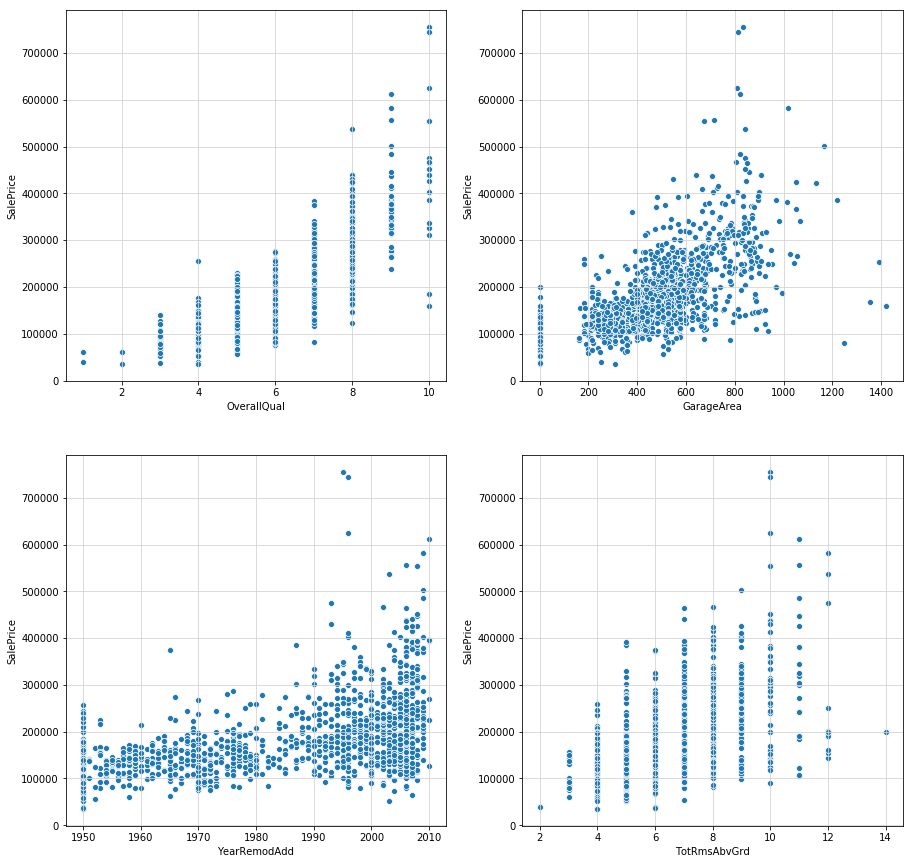

In [9]:
fig, axarr = plt.subplots(2,2,figsize=(15,15))
sns.scatterplot(x='OverallQual',y='SalePrice',data=train_set,ax=axarr[0][0]).grid(b=True, color='lightgrey')
sns.scatterplot(x='GarageArea',y='SalePrice',data=train_set,ax=axarr[0][1]).grid(b=True, color='lightgrey')
sns.scatterplot(x='YearRemodAdd',y='SalePrice',data=train_set,ax=axarr[1][0]).grid(b=True, color='lightgrey')
sns.scatterplot(x='TotRmsAbvGrd',y='SalePrice',data=train_set,ax=axarr[1][1]).grid(b=True, color='lightgrey')


In [10]:
index = train_test[(train_test.OverallQual==10) & (train_test.SalePrice<200000)].index
train_test = train_test.drop(index,axis=0)

index = train_test[(train_test.GarageArea>1200) & (train_test.SalePrice<300000)].index
train_test = train_test.drop(index, axis=0)

index = train_test[(train_test.YearRemodAdd<1970) & (train_test.SalePrice>300000)].index
train_test = train_test.drop(index,axis=0)

index = train_test[(train_test['TotRmsAbvGrd']==14)].index
train_test = train_test.drop(index,axis=0)

## Lot Frontage missing values

In order to replace missing values in *LotFrontage*, I decided to use Lasso model where Frontage is response variable and train set contains all other variables besides *SalePrice*.

In [11]:
train_test1 = train_test.copy()
train_test1 = pd.get_dummies(train_test1)


trainX = train_test1[train_test1.LotFrontage.isnull()==False].drop(['SalePrice','LotFrontage'],axis=1)
testX = train_test[train_test.LotFrontage.isnull()==True].drop(['SalePrice','LotFrontage'],axis=1)
trainY = train_test1.LotFrontage[train_test1.LotFrontage.isnull()==False]

trainx, testx, trainy, testy = train_test_split(trainX, np.log(trainY), test_size=0.3, random_state=0)
model = Lasso(alpha=0.0009)
model.fit(trainx,trainy)
Predictions = model.predict(testx)
MSE = np.sqrt(mean_squared_error(np.exp(testy),np.exp(Predictions)))
print('LotFrontage MSE:',MSE,'\nMSE / LotFrontage mean ratio:', MSE/(np.exp(testy.mean())))

LotFrontage MSE: 14.087653170512432 
MSE / LotFrontage mean ratio: 0.21357511842304386


As you may see above, LotFrontage predictions deviate from real values by 14 units which is around 21% of its mean value. This value seems to be good enough, especially, that probably this feature is not very significant in prediction model.

In [12]:
trainX = train_test1[train_test1.LotFrontage.isnull()==False].drop(['SalePrice','LotFrontage'],axis=1)
testX = train_test1[train_test1.LotFrontage.isnull()==True].drop(['SalePrice','LotFrontage'],axis=1)
trainY = train_test1.LotFrontage[train_test1.LotFrontage.isnull()==False]


model = Lasso(alpha=0.0009)
model.fit(trainx,trainy)
Predictions = model.predict(testX)
train_test.loc[train_test.LotFrontage.isnull()==True, 'LotFrontage'] = Predictions

## Feature engineering
At this stage, we will try to create some additional variables which may improve our model and reduce skewnesses.

As you may see on plots below, *SalePrice* is skewed into right, which means, that most of the values are smaller than mean value. Most of machine learning models are able to perform much better while response variable is closer to normal distribution, so we will keep that in mind and transform it just before creating final model.

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

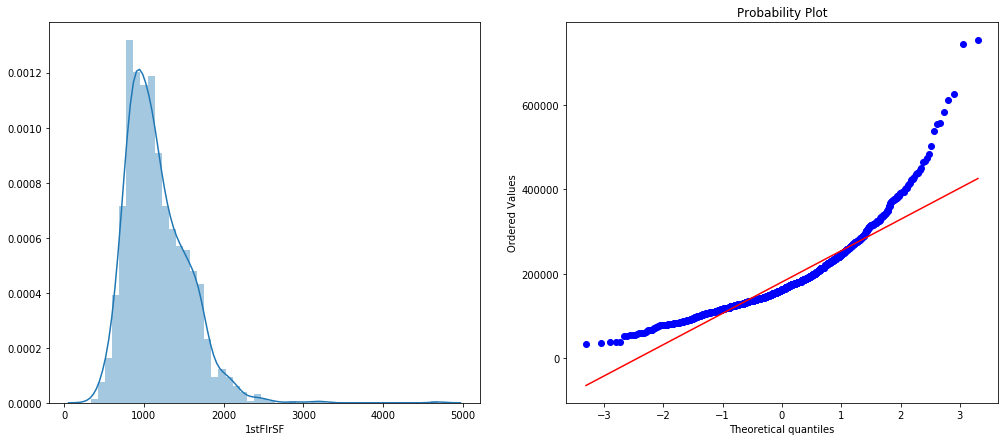

In [13]:
fig, axarr = plt.subplots(1,2,figsize=(17,7))
sns.distplot(train_set['1stFlrSF'],ax=axarr[0])
probplot(train_set.SalePrice, plot=plt)

Now, I will try to explain what idea stands behind creating each variable. Obviously, the fact that we are adding variable into the dataset does not mean that we will receive better results. Some of them may have positive influence on a model while others do the opposite. It is our role to determine whether specific feature helps or not. While preparing the dataset I decided to implement following features:

* *t* - tells when the transaction was done
* *GarageQualityOverall* - it is not specified what is the difference between quality and condition, so I decided to merge those two variables together to receive an overall score for garage. The same logic applies to *OverallQuality*, *BasementQuality* and *ExteriorQuality*
* *AllStoriesFinished* - if a story is not finished, it should have negative influence on house's value
* *CanHold2Cars* - if we will assume that typical family in Ames have two cars, then value 2 can be threshold when reached can significantly increase property value
* *AfterCrysis* - properties sold and after 2007 should have smaller price than those sold before 2008
* *IsFresh* - newly refurbished houses probably have higher prices than the others
* *Fireplaces_times_FireplaceQu* - multiplying these two variables result in overall score for all fireplaces
* *YearBltandYearRemodAdd* - the higher sum of *YearBlt* and *YearRemodAdd* is, the higher value of property should be
* *SeasonForBuing* - according to some external sources, the best months to buy property are March, April, May, June
* *RichNeighborhood* - I decided to subjectively bin Neighborhoods, because their individual influence of the property being in each neighborhood seemed to be too low to change SalePrice significantly. Scale of measurement is ordinal from 1 to 5 where by 1 we denote poorest neighborhoods and by 5 the richest ones

The rest of the variables seems to be self explanatory

In [14]:
train_test['t'] = train_test.YrSold.map({2006:1, 2007:2, 2008:3, 2009:4, 2010:5})
train_test.t = train_test.MoSold * train_test.t
train_test = train_test.replace({'MoSold':{1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:
                                           'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}})

train_test['GarageQualityOverall'] = train_test.GarageQual + train_test.GarageCond
train_test['HasPool'] = train_test.PoolQC.map(lambda x: 1 if x>0 else 0)
train_test['HasGarage'] = train_test.GarageFinish.map(lambda x: 1 if x>0 else 0)
train_test['HasFireplace'] = train_test.Fireplaces.map(lambda x: 1 if x>0 else 0)
train_test['HasBasement'] = train_test.TotalBsmtSF.map(lambda x: 1 if x>0 else 0)
train_test['AllStoriesFinished'] = train_test.HouseStyle.map(lambda x: 0 if (x=='1.5Unf' or x=='2.5Unf') else 1)
train_test['CanHold2Cars'] = train_test.GarageCars.map(lambda x: 1 if x>=2 else 0)
train_test['AfterCrisis'] = train_test.YrSold.map(lambda x: 1 if x>=2008 else 0) 


closed = train_test['EnclosedPorch'] + train_test['3SsnPorch'] + train_test['ScreenPorch'] 
opened = train_test['WoodDeckSF'] + train_test['OpenPorchSF']
train_test['PorchArea'] = closed + opened
train_test['HasPorch'] = train_test['PorchArea'].map(lambda x: 1 if x>0 else 0)
train_test['PorchClosed'] = closed.map(lambda x: 1 if x > 0 else 0)

IsFresh = train_test[(train_test.YearRemodAdd == train_test.YrSold)].index
train_test['IsFresh'] = train_test.index.map(lambda x: 1 if x in IsFresh else 0)

train_test['BsmtFinType'] = train_test.BsmtFinType2 + train_test.BsmtFinType1
train_test['BsmtUnfinPercent'] = train_test.BsmtUnfSF / train_test.TotalBsmtSF
train_test.loc[train_test['BsmtUnfinPercent'].isnull(),'BsmtUnfinPercent'] = 0
train_test['TotalHouseSF'] = train_test.TotalBsmtSF + train_test.GrLivArea

train_test['AmtOfStories'] = 0
train_test.loc[train_test.HouseStyle=='1Story','AmtOfStories'] = 1
train_test.loc[(train_test.HouseStyle=='1.5Fin') | (train_test.HouseStyle=='1.5Unf'), 'AmtOfStories'] = 1.5
train_test.loc[(train_test.HouseStyle=='2.5Fin') | (train_test.HouseStyle=='2.5Unf'), 'AmtOfStories'] = 2.5
train_test.loc[(train_test.HouseStyle=='2Story'), 'AmtOfStories'] = 2

train_test['OverallQuality'] = train_test.OverallQual + train_test.OverallCond
train_test['BasementQuality'] = train_test.BsmtCond + train_test.BsmtExposure
train_test['Bathrooms'] = train_test.BsmtFullBath + train_test.BsmtHalfBath/2 + train_test.FullBath + train_test.HalfBath/2
train_test['ExteriorQuality'] = train_test.ExterQual + train_test.ExterCond
train_test['Fireplaces_times_FireplaceQu'] = train_test.Fireplaces * train_test.FireplaceQu
train_test['BsmtFinSF'] = train_test.BsmtFinSF1 + train_test.BsmtFinSF2
train_test['YearBltandYearRemodAdd'] = train_test.YearBuilt + train_test.YearRemodAdd

train_test['GarageTypeGrades'] = train_test.GarageType.replace({'2Types':6,'Attchd':5,'Basment':4,'BuiltIn':3,'CarPort':2,'Detchd':1,'No_garage':0})

Season = ['Mar', 'Apr', 'May', 'Jun']
train_test['SeasonForBuing'] = train_test.MoSold.map(lambda x: 1 if x in Season else 0)


train_test = train_test.drop('Utilities',axis=1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

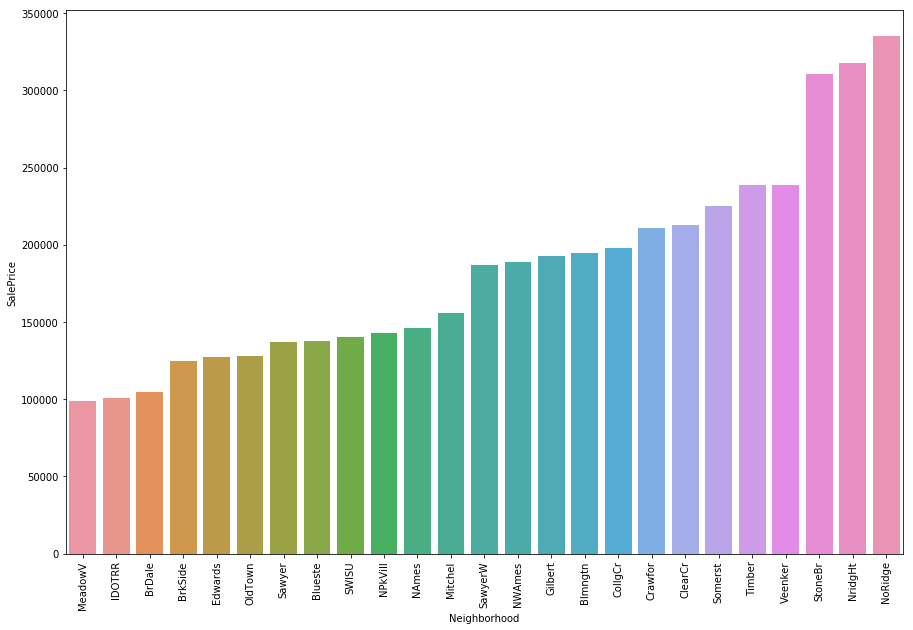

In [15]:
NeighborhoodsBinned = train_test[:1459][['Neighborhood','SalePrice']].groupby('Neighborhood').mean().sort_values(by='SalePrice')

plt.figure(figsize=(15,10))
sns.barplot(x=NeighborhoodsBinned.index, y=NeighborhoodsBinned.SalePrice)
plt.xticks(rotation=90)

As you may see on the chart above, mean values of *SalePrice* in each neighborhood are kinda grouping together. First three have similar value to each other, next 9 of them also have similar means and so on. After each interval of similar means there is a big jump in mean values. Those jumps will determine the limits of each interval. 

In [16]:
train_test['RichNeighborhood'] = np.NaN
ones = NeighborhoodsBinned[0:3].index
twos = NeighborhoodsBinned[3:12].index
threes = NeighborhoodsBinned[12:19].index
fours = NeighborhoodsBinned[19:22].index
fives = NeighborhoodsBinned[22:].index

i=0
for variable in [ones, twos, threes, fours, fives]:
    i += 1
    for neighborhood in variable:
        train_test.loc[train_test.Neighborhood==neighborhood,'RichNeighborhood'] = i
        
train_test = train_test.drop('Neighborhood',axis=1)

In next step I am going to merge categories which do not have too much observations. Obviously this is very subjective and someone while having variable with three categories which have respectively 1000, 50 and 20 observations may want to merge two smallest categories, but someone else may want to leave it as it is.

In [17]:
train_test.Exterior1st = train_test.Exterior1st.map(lambda x: 'Other' if (x!='CemntBd' and x!='VinylSd') else x)
train_test.Exterior2nd = train_test.Exterior2nd.map(lambda x: 'Other' if (x!='CemntBd' and x!='VinylSd') else x)
train_test.Functional = train_test.Functional.map(lambda x: 'Other' if x!='Typ' else x)
train_test.GarageYrBlt = train_test.GarageYrBlt.map(lambda x: 'DNE' if x==0 else 'Classic' if x<=1935 else 'Modern' if x>=1995 else 'Mid-age')
train_test.SaleType = train_test.SaleType.map(lambda x: 'Other' if x!='WD' else x)
train_test.SaleCondition = train_test.SaleCondition.map(lambda x: 'Other' if (x!='Normal' and x!='Partial') else x)
train_test.Condition1 = train_test.Condition1.map(lambda x: x if x in ['Norm', 'Feedr', 'Artery'] else 'Other')
train_test.RoofMatl = train_test.RoofMatl.map(lambda x: 'Other' if x!='CompShg' else x)

train_test = train_test.replace({'BldgType':{'Duplex':'Other', 'Twnhs':'Other', '2fmCon':'Other'},
                                'Electrical':{'FuseF':'Other','FuseP':'Other','Mix':'Other'},
                                 'Foundation':{'Slab':'Other','Stone':'Other','Wood':'Other'},
                                 'Heating':{'Grav':'Other','Wall':'Other','OthW':'Other','Floor':'Other'},
                                 'HouseStyle':{'2.5Unf':'Other','1.5Unf':'Other','2.5Fin':'Other'},
                                 'MSSubClass':{'1-1/2 STORY PUD - ALL AGES':'Other','1-STORY W/FINISHED ATTIC ALL AGES':'Other'\
                                 ,'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER':'Other','1-1/2 STORY - UNFINISHED ALL AGES':'Other'\
                                 ,'2-1/2 STORY ALL AGES':'Other'},
                                 'MSZoning':{'RH':'Other','C (all)':'Other'},
                                 'MiscFeature':{'Gar2':'Other','TenC':'Other'}})

Now I am going to add some logarithms and squares into the dataset to reduce its skewness. Amount of skewed variable is much greater than you can see below, but transformation of those specific variables resulted for me in better score, while other transformations affected negatively model. Also, I decided to drop few variables which appeared to negatively influence final score when transformation happend.

In [18]:
for var in ['1stFlrSF','BsmtFinSF2','MasVnrArea', 'BsmtFinSF', 'TotalBsmtSF', 'TotalHouseSF']:
    train_test['LOG{}'.format(var)] = np.log(1+train_test[var]) 

train_test['LOGYearBltandYearRemodAdd'] = train_test['YearBltandYearRemodAdd']**2


train_test = train_test.drop(['1stFlrSF','BsmtFinSF','TotalBsmtSF'],axis=1)

## Creating model
I decided to blend together results of three separate models - Lasso, ElasticNet and XGBoost while giving ElasticNet doubled weight on overall results. Before creating model I decided to delete some variables which have negative influence on overall score. There was no specific to detect them - only trial and error.

In [19]:
train_test.SalePrice = np.log(train_test.SalePrice)

train_test = train_test.drop(['GarageQual','GarageCond','EnclosedPorch','3SsnPorch','OpenPorchSF','BsmtFinType2','BsmtFinType1','BsmtUnfSF','GrLivArea',
                               'BsmtCond','BsmtExposure','BsmtFullBath','BsmtHalfBath','FullBath','ExterCond'],axis=1)

In [20]:
y = (train_test.SalePrice[train_test.SalePrice.isnull()==False])
train_test = pd.get_dummies(train_test)
X = train_test[train_test.SalePrice.isnull()==False].drop('SalePrice',axis=1)
testX = train_test[train_test.SalePrice.isnull()==True].drop('SalePrice',axis=1)

model = Lasso(alpha = 0.0008)
model.fit(X,y)
predictions = model.predict(testX)

model = ElasticNet(alpha = 0.0008)
model.fit(X,y)
predictions2 = model.predict(testX)

model = XGBRegressor(n_estimators=4500)
model.fit(X,y)
predictions3 = model.predict(testX)

predictions = (predictions + predictions2 + predictions2 + predictions3)/4

Final = pd.DataFrame({'Id':range(1461,2920),'SalePrice': np.exp(predictions)}).set_index('Id')
Final.to_csv(r'Blended.csv')

[19:00:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Final thoughts
There are a couple of things which may or may not improve the model from current state:

1. Conducting more sophisticated outlier detection - from what I know, some other kernel creators are using Z-Score for univariate outliers detection and residuals. From what I have seen so far, deleting just few outliers may drastically improve results
2. As I said before, connecting categories is very subjective - it is probably possible to improve the score by changing the way categories are connected
3. Feature selection may be done better (for example by using Random Forest)
4. I did not spend too much time with hyperparameters, so boosting them may also help
5. As we may see on chart below, observation with actual value higher than 300000 seems to have worse prediction results than the rest of them. Some kind of improving prediction results of those observations (eg. dividing into two separate models) may be helpful

[19:00:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


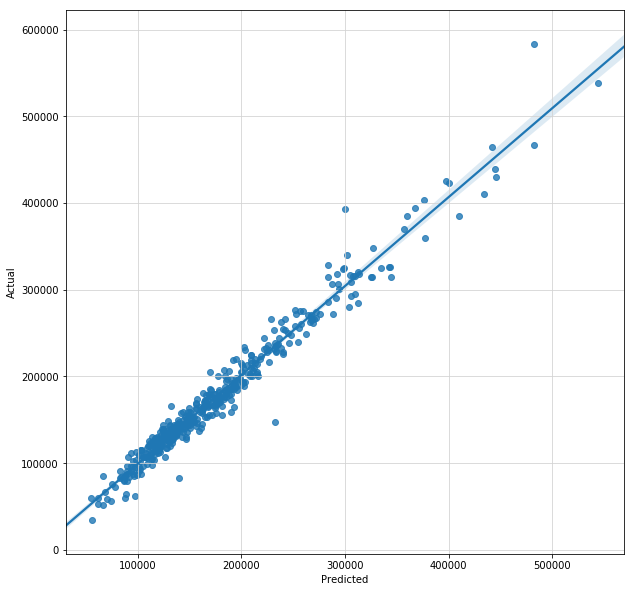

In [21]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
model = Lasso(alpha = 0.0008)
model.fit(X,y)
predictions = model.predict(testX)

model = ElasticNet(alpha = 0.0008)
model.fit(X,y)
predictions2 = model.predict(testX)

model = XGBRegressor(n_estimators=4500)
model.fit(X,y)
predictions3 = model.predict(testX)

predictions = (predictions + predictions2 + predictions2 + predictions3)/4

plt.figure(figsize=(10,10))
Results = pd.DataFrame({'Actual':np.exp(testY),'Predicted':np.exp(predictions)})
sns.regplot(x='Predicted', y='Actual', data=Results).grid(b=True,color='lightgrey')